# Feature Engineering at `sklearn`

The purpose of this Notebook is **to introduce, in a hands-on way, the feature engineering cycle with `sklearn`**.

In [55]:
import random

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, PowerTransformer

from sklearn.metrics import r2_score

# 1 Data

We started by building our dataset, using the [California Housing] (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) dataset.

For this example, we have included some missing values, at random (it is possible to "play" with the number of missing values).

Detailed documentation on the dataset in the [User Guide] (https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset).

In [56]:
def collect_data(n_missing=100):
    # Load the sklearn dataset.
    california_housing = fetch_california_housing()
    
    # Create a pd.DataFrame with all the features.
    X = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
    # Create an array with all labels.
    y = california_housing.target
    
    # Add missing values at random.
    X_miss =  add_synthetics_missing_values(X, n_missing)
    
    return X_miss, y

def add_synthetics_missing_values(X, n_missing):
    
    X_ = X.copy()
    
    nrow, ncol = X_.shape
    
    miss_rows = [random.randint(0, nrow - 1) for i in range(0, n_missing)]
    miss_cols = [random.randint(0, ncol - 1) for i in range(0, n_missing)]
    
    for r, c in zip(miss_rows, miss_cols):
        X_.iloc[r, c] = np.NaN
        
    return X_
    

X, y = collect_data()
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## Exercise 1.1

We calculate the number of missing values per column.

In [57]:

### BEGIN SOLUTION
X.isnull().sum()
num_missing = X.isnull().sum()
 

### END SOLUTION
num_missing

MedInc        12
HouseAge      10
AveRooms       9
AveBedrms     15
Population    18
AveOccup      12
Latitude      11
Longitude     13
dtype: int64

In [58]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

# 2 Problem framing

## Exercise 2.1

Based on the above evidence and the description of the dataset, we are faced with a problem:
- [x] Supervised.
- [ ] Unsupervised.
- [ ] Semi-supervised.

In addition, we refer to the histogram of the *labels*, which correspond to the **value of the house** (in units of $100,000).

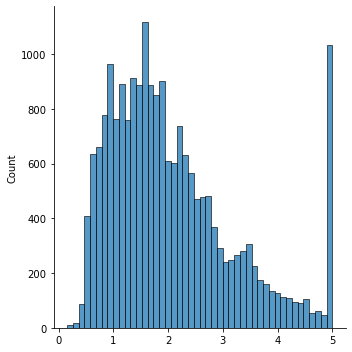

In [59]:
sns.displot(y);

## Exercise 2.2

Based on the description of the labels and the histogram above, we characterize the problem as:
- [No] Regression.
Because we are trying to predict a continuous variable between 0 and 5
- [No] Classification.
The variable (price) is continuous and not categorical
- [No] Ranking.
The ranking tends to create a numerical order based on the relevance of the features
- [No] Active learning.
It is not active learning because we have the labels all necessary for our forecast
- [No] Transfer learning.
The model does not have information previously passed to perform new learning
- [No] Reinforcement learning.
The model does not include the notion of reward

Please **justify the answer (yes / no) for each option**.

## Exercise 2.3

Based on the analysis of the histogram above, **is there any reason to doubt the quality of the labels**? Why?
What would be a potential explanation?

*** Yes, it can be deduced that the model has a tail on the right, that is, it presents outliers (extreme values), which were compressed using clipping (maximum value), in this case the value 5.

# 3 Training and testing

## Exercise 3.1

Then, **we partition the data between training (70%) and test (30%)**, at random.

In [60]:

### BEGIN SOLUTION
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
### END SOLUTION


In [61]:
y_train.shape

(14448,)

#### Testes

In [62]:
assert X_train.shape == (14448, 8)
assert y_train.shape == (14448,)
assert X_test.shape == (6192, 8)
assert y_test.shape == (6192,)

# 4 sklearn transformations

In the `sklearn` library we can find [transformers] (https://scikit-learn.org/stable/modules/preprocessing.html), a set of classes that provide, among other things:
- The most common transformations in feature engineering in an easy to use ("plug-and-play") way.
- That all parameters are calculated, exclusively, based on the training dataset.
- That all transformations and parameters are saved for future use in the transformation in the training dataset.

The feature summary (for reference) can be found at [6.3 Preprocessing data] (https://scikit-learn.org/stable/modules/preprocessing.html) in the library documentation.

Typically, all classes of this type implement the following methods (and should be used as follows).

In [63]:
#transformer = Transformer(param_1=..., param_2=, ...)

# Calculates all necessary parameters based on the training dataset (e.g., average).
# transformer.fit(X_train)

# Apply the transformation, based on the parameters calculated in the training dataset, in training.
# transformer.transform(X_train)

# Note, that transformers implement a convenient method to fit and transform, simultaneously, into training.
# transformer.fit_transform(X_train)

# Finally, for the final evaluation of the generalization error in the test dataset, we apply only the transformation.
# transformer.fit_transform(X_test)

# 5 Linear regression

In this exercise we will use, exclusively, [linear regression] (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [64]:
lr = LinearRegression()

Linear regression is a simple parametric model, whose main assumptions are:
1. **Linearity**.
2. **Homoscedasticity**.
3. **Independence**.
4. **Normality**.

Finally, the implementation of the algorithm, **does not support the presence of missing values**.
Our purpose in this notebook is to **assess the impact of various feature engineering techniques**.

# 6 Baseline

It is common to start by **creating a *baseline* based on a numeric feature** using a **simple model**.

## Exercise 6.1

Let's start by visualizing the joint distribution between the features and our target (i.e., the price).

**Note**: Note that we use the training dataset exclusively.

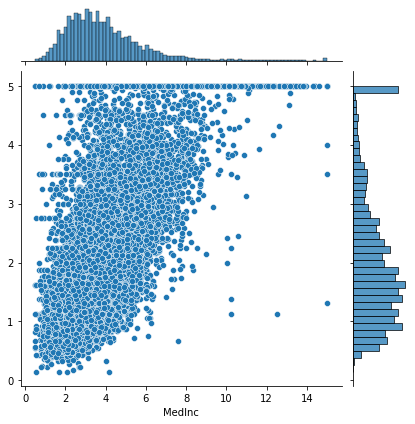

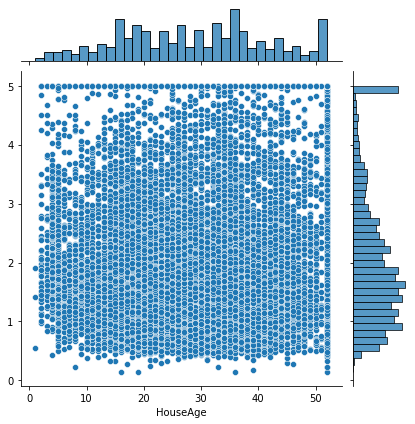

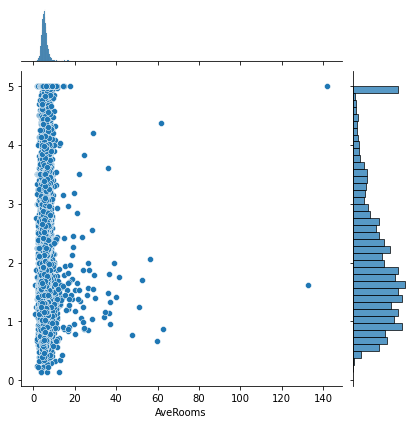

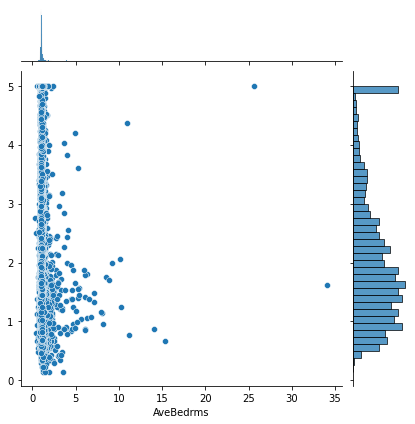

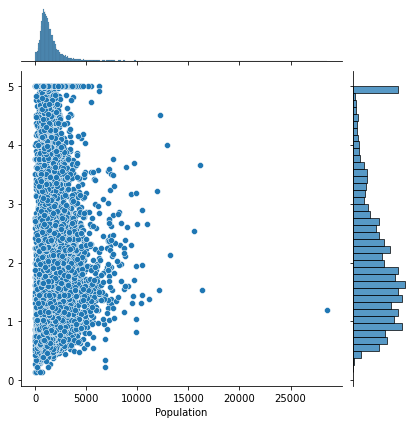

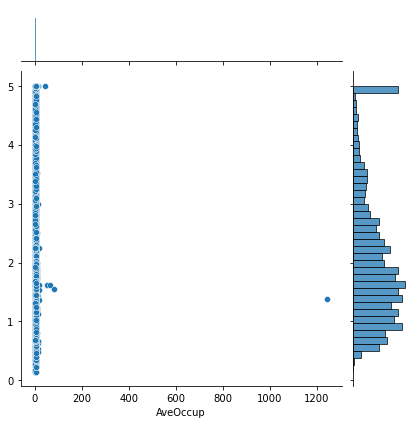

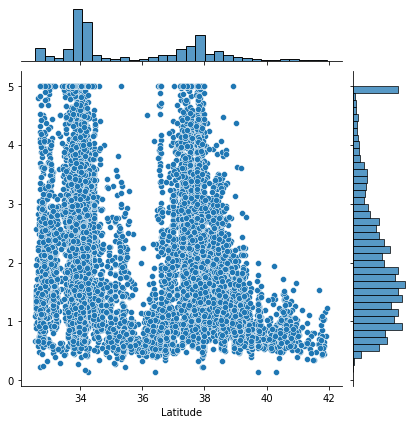

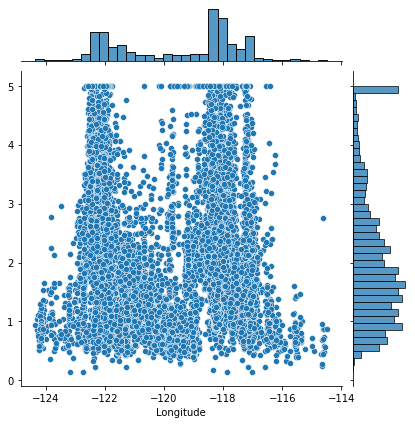

In [65]:
for col in X_train.columns:
    sns.jointplot(x=X_train[col], y=y_train);

What conclusions can we draw about each of the variables?

- `MedInc`.
- `HouseAge`.
- `MedInc`.
- `AveRooms`.
- `AveBedrms`.
- `Population`.
- `AveOccup`.
- `Latitude`.
- `Longitude`.

Again, for details on what each of the variables means, consult the [User Guide] (https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset).

## Exercise 6.2

We then started by training a model using only the `MedInc` feature.

However, we have to check, again, **the number of missing values**.

In [66]:
### BEGIN SOLUTION
X.MedInc.isnull().sum()
### END SOLUTION

12

We calculated the same value **as a percentage of total observations**.

In [67]:
### BEGIN SOLUTION
medincmiss =  ( X.MedInc.isnull().sum() / X.MedInc.count() ) * 100
medincmiss
### END SOLUTION


0.058173356602675974

Given the relatively low percentage of missing values, **we will charge with the average**, using the `sklearn` transformer` SimpleImputer`.

In [68]:
X_train_imputed = SimpleImputer(missing_values= np.nan, strategy= 'mean')
X_train_imputed = X_train_imputed.fit_transform(X_train)

Finally, let's look at the distribution before and after the imputation of the missing values.

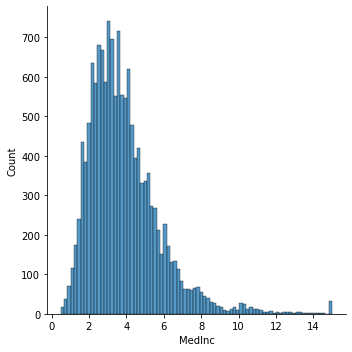

In [69]:
sns.displot(X_train['MedInc']);

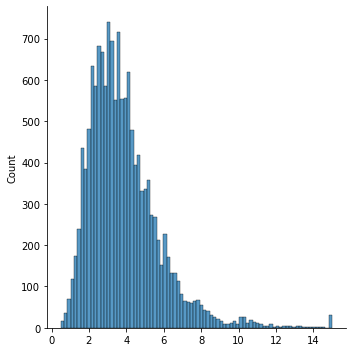

In [70]:
sns.displot(X_train_imputed[:, 0]);

**Finally, let's look at the distribution before and after the imputation of the missing values.**

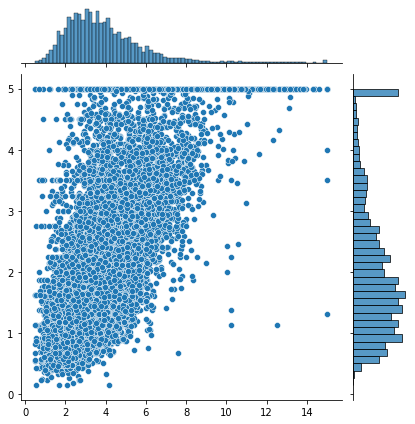

In [71]:
sns.jointplot(x=X_train_imputed[:, 0], y=y_train);

However, the `MedInc` variable has an obvious **bias** (choose the correct option):
- [x] Positive.
- [ ] Negative.

## Exercise 6.3

We will now evaluate our baseline, using:
- Linear regression (instantiated above).
- Only the `MedInc` feature (without missing values; as imputed above).

The models (i.e., [Estimators] (https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) in `sklearn`) work in a similar way to transformers:
- We use `estimator.fit ()` to train the model and save it for future predictions.
- We use `estimator.predict ()` to make predictions based on the previously trained model (equivalent to the `.transform ()` of the transformers, above).

In [72]:
# Train the model using lr.fit () and the training dataset.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit

X_train_imputed_MedInc = X_train_imputed[:, 0].reshape(-1, 1)
lr_fit = LinearRegression().fit(X_train_imputed_MedInc, y_train)

In [73]:
# We make predictions for the training dataset using lr.predict ().
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict

y_train_pred = lr_fit.predict(X_train_imputed_MedInc)

y_train_pred

array([3.28859522, 2.28711484, 1.71997079, ..., 2.23948091, 1.49214547,
       1.72034618])

## Exercise 6.4

We will use the [R^2 score or coefficient of determination] (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score) as an error measure for our predictions.

We will talk, in detail, about evaluation metrics in the next classes.

Once again, our goal on this notebook is **to use tools for feature engineering**.

In [74]:
r2_score(y_train, y_train_pred)

0.47483494112597036

## Exercise 6.5

Finally, we will repeat the entire process for the test dataset and calculate the coefficient of determination.

In [75]:
X_test_imputed = SimpleImputer(missing_values= np.nan, strategy= 'mean')
X_test_imputed = X_test_imputed.fit_transform(X_test)
X_test_imputed_MedInc = X_test_imputed[:, 0].reshape(-1, 1)
lr_fit = LinearRegression().fit(X_test_imputed_MedInc, y_test)
y_test_pred = lr_fit.predict(X_test_imputed_MedInc)

mae_test = r2_score(y_test, y_test_pred)

mae_test

0.46916493858454267

Based on the results above, **what we conclude regarding**:
- Bias-variance trade-off?

The bias vs trade off is reduced, because there is a high bias due to a reduced variance.

- Next steps in modeling?

Perform the same process including more features and another partitioning strategy

# 7 Pipelines

The above process, of manually replicating the necessary feature engineering and model steps, is time-consuming and error-prone.

Fortunately, the `sklearn` library supports the concept of **pipeline** to store, in a single object, **a sequence of transformations, followed by an estimator**.

We can think of **pipeline** as our model, including all the steps of feature engineering, modeling and **all the parameters needed for future forecasts**.

**We will thus replicate our previous model** (analyze, line by line, carefully).

In [76]:
model = Pipeline([
    ('Imputing missing values', SimpleImputer()),
    ('Regression', LinearRegression()),
])

model.steps

[('Imputing missing values', SimpleImputer()),
 ('Regression', LinearRegression())]

We estimate **the parameters of the transformation** (in this case, the imputation of values based on the mean) **and the model** in **simultaneous**.

In [77]:
# We use X_train[['MedInc']] because the pipeline requires a pd.DataFrame and not a pd.Series.
# Therefore, using X_train['MedInc'] will throw an error. You can try if you want. :)
model.fit(X_train[['MedInc']], y_train)

Pipeline(steps=[('Imputing missing values', SimpleImputer()),
                ('Regression', LinearRegression())])

And we use the model to ** make predictions **.

**Note**: when using `Pipeline.predict ()` the pipeline runs all the steps, including transformations (i.e., it is not necessary to run `Pipeline.transform ()`).

In [78]:
model.predict(X_train[['MedInc']])

array([3.28859522, 2.28711484, 1.71997079, ..., 2.23948091, 1.49214547,
       1.72034618])

The use of pipelines makes it much easier to:

- Guarantee **consistency between training and forecasting operations**.
- Ensure best practices, namely **the estimation of parameters only in the training sample**.

# 8 Cross-validation

The model, i.e., the pipeline, can be used for cross validation, while `sklearn` guarantees the separation, in all folds, between training and validation.

This makes **evaluation of different feature engineering configurations** much easier.

## Exercise 8.1

As we have seen, our validation process above has a flaw: **we are using the test dataset to estimate the generalization error too early**.

Thus, we run the risk of "burning" the test dataset and the ability to estimate the generalization error for the final model.

Therefore, we evaluated the model above, i.e., the pipeline, using ***k* -fold cross-validation with 5 folds**.

In [79]:
results = cross_val_score(model, X_train, y_train)
results_mean = results.mean()
results_std = results.std()

In [80]:
results

array([-3.50801676,  0.62742454,  0.60521912,  0.57255491,  0.61363374])

**So, let's look at the results.**

In [81]:
results_mean

-0.2178368924142911

In [82]:
results_std

1.6451890005613496

Do these results **confirm the answers above about bias-variance trade-off and next steps**? Why?

***It does confirm, because by checking more variance (more features) and applying cross-validation, we get a higher bias vs trade off as can be seen in the result above***

# 9 Numeric Features

So, let's go back to looking at our data.

In [83]:
X_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
4005,6.8107,29.0,6.993590,1.036859,1550.0,2.483974,34.16,-118.61
14643,4.4097,34.0,6.378882,1.031056,1659.0,2.576087,32.78,-117.19
20106,3.0500,17.0,5.383764,1.095941,753.0,2.778598,37.94,-120.29
16259,3.0352,41.0,5.400901,1.009009,1143.0,2.574324,37.97,-121.26
2175,2.9315,27.0,5.118644,1.166102,847.0,2.871186,36.77,-119.85


We identified some numeric features that can be easily used to enrich our feature vector (we marked the numeric features, below):

- [ ] `HouseAge`
- [ ] `AveRooms`
- [ ] `AveBedrms`
- [ ] `Population`
- [ ] `AveOccup`
- [ ] `Latitude`
- [ ] `Longitude`

## Exercise 9.1

We will build a pipeline with the following steps:
- **Imputation of missing values** with [`SimpleImputer`] (https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html).
- Gaussian Transformation (**ensure "data normality"**) with [PowerTransformer] (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html).

In [84]:
feng = Pipeline([
    ('Imputing missing values', SimpleImputer()),
    ('Data Normality', PowerTransformer(method='box-cox'))])

feng.steps

[('Imputing missing values', SimpleImputer()),
 ('Data Normality', PowerTransformer(method='box-cox'))]

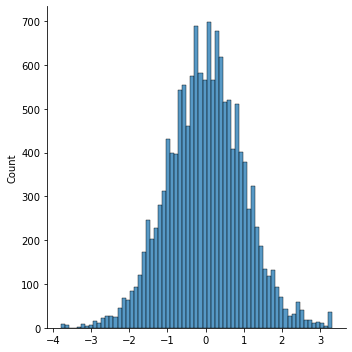

In [85]:
X_train_ = feng.fit_transform(X_train[['MedInc', 'HouseAge', 'AveRooms', 'AveOccup']])

# MedInc
sns.displot(X_train_[:, 0]);

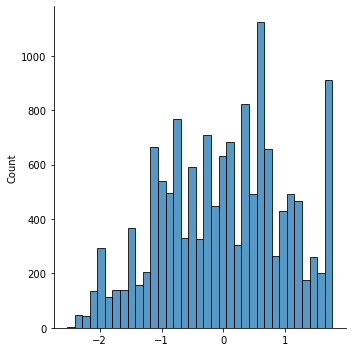

In [86]:
# HouseAge
sns.displot(X_train_[:, 1]);

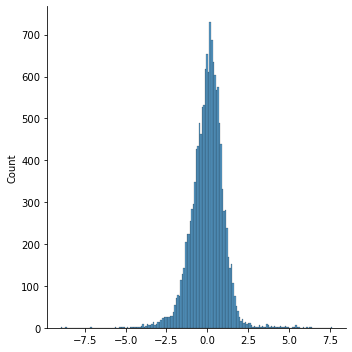

In [87]:
# AveRooms
sns.displot(X_train_[:, 2]);

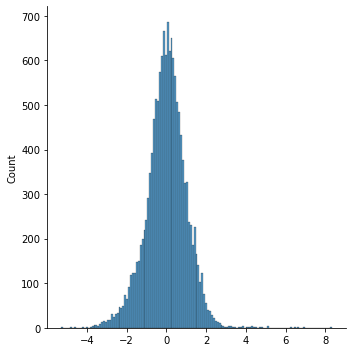

In [88]:
# AveOccup
sns.displot(X_train_[:, 3]);

**Given the histograms above, we will not be using the `HouseAge` feature.**

## Exercise 9.2

Evaluate the model, using the feature engineering steps above, followed by a logistic regression, using cross-validation.

We must use the following features:
- `MedInc`.
- `AveRooms`.
- `AveOccup`.

In [89]:
X_train__ = X_train[['MedInc', 'AveRooms', 'AveOccup']]

model_v2 = Pipeline([
    ('Feature engineering', feng),
    ('Regression', LinearRegression())])

results_v2 = cross_val_score(model_v2, X_train__, y_train)
results_mean_v2 = results_v2.mean()
results_std_v2 = results_v2.std()

In [90]:
results_v2

array([0.52345291, 0.53611173, 0.51929295, 0.49615365, 0.52704559])

In [91]:
results_mean_v2

0.5204113686453302

In [92]:
results_std_v2

0.013337563633860513

What can we conclude **comparing this new model with the baseline**?

# 10 Binning and categorical features

Finally, **we will incorporate latitude and longitude features**.

However, this adds a new complexity: we will have to have separate transformations for the numeric features and for the location.

## Exercise 10.1

Let's start by creating a [ColumnTransformer] (https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) (see documentation carefully) that does the following:
- Apply `PowerTransformer` for numeric features (those used above).
- Apply `KBinsDiscretizer` for latitude and longitude (` Latitude` and `Longitude`).

The [KBinsDiscretizer] (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html) (see documentation carefully) **transforms continuous variables into categorical variables**, by creating bins.

For our convenience, **returns categorical variables using one-hot encoding by default**.

In [93]:
feng_v2 = ColumnTransformer(
    [('num', PowerTransformer(), slice(0, 3)),
     ('cat', KBinsDiscretizer(n_bins=20), slice(3, 5))
    ])

## Exercise 10.2

Let's create `model_v3`, incorporating all the steps:

- Imputation of missing values.
- The feature engineering process implemented above, in 10.1.
- Linear regression.

In [94]:
model_v3 = Pipeline([
    ('Imputing missing values', SimpleImputer()),
    ('Feature engineering 2', feng_v2),
    ('Linear Regression', LinearRegression()),
])

## Exercise 10.3

Finally, we evaluated the new version of the model with cross-validation.

In [95]:
X_train_v1 = X_train[['MedInc', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude']]

results_v3 = cross_val_score(model_v3, X_train_v1, y_train)
results_mean_v3 = results_v3.mean()
results_std_v3 = results_v3.std()

In [96]:
results_v3

array([0.61414442, 0.64675144, 0.64642322, 0.6168696 , 0.63592876])

In [97]:
results_mean_v3 

0.6320234848631459

In [98]:
results_std_v3 

0.014062840619429239

What conclusions can we draw about the **performance of the new features** (taking time to think and analyze the results)?

Applying binning to latitude and longitude makes the model perform better

# 11 House age

## Exercise 11.1

Looking for a way to **incorporate the information from the `HouseAge`** feature into the model, reporting the results.

In [99]:
feng_v3 = ColumnTransformer(
    [('num', PowerTransformer(), slice(0, 4)),
     ('cat', KBinsDiscretizer(n_bins=20), slice(4, 6))
    ])

model_v4 = Pipeline([
    ('Imputing missing values', SimpleImputer()),
    ('Feature engineering 2', feng_v3),
    ('Linear Regression', LinearRegression()),
])

X_train_v2 = X_train[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude']]

results_v3 = cross_val_score(model_v4, X_train_v2, y_train)
results_mean_v3 = results_v3.mean()
results_std_v3 = results_v3.std()

In [100]:
results_v3

array([0.61569815, 0.64890908, 0.64797548, 0.61882663, 0.63927034])

In [101]:
results_mean_v3

0.634135935157753

In [102]:
results_std_v3

0.014215959031112281

# 12 Generalization error

## Exercise 12.1

Calculates the generalization error of the best model in the **test dataset**.

In [103]:
model_v4.fit(X_train_v2, y_train)
y_predict = model_v4.predict(X_test[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude']])

r2 = r2_score(y_test, y_predict)

r2

# there is a 63-64% probability of predicting the price in y_test based on the trained variables (features) of y_predict


0.6453847681341273

# Recap

In this notebook we saw how to **use the essential tools** of feature engineering in `sklearn`.

For a list of the main transformers in the library consult:
- [Pipelines and composite estimators] (https://scikit-learn.org/stable/modules/compose.html).
- [Preprocessing data] (https://scikit-learn.org/stable/modules/preprocessing.html).
- [Imputation of missing values] (https://scikit-learn.org/stable/modules/impute.html).

All transformers in `sklearn` follow **exactly the same structure**, as presented in this notebook, with two essential methods:` .fit () `and` .transform () `.

For ideas on which transformations to apply in which situation, **use slides from the Feature Engineering class as a reference**.

These transformers must be combined in `Pipelines`, together with the estimator to be used (i.e., they are part of the model).

Using `Pipelines` facilitates the cross-validation process, ensuring separation between validation and training data.